In [2]:
import Test.@test
import Test.@testset

import LinearAlgebra: Diagonal, tr

import Keldysh; kd = Keldysh;

import KeldyshED; ked = KeldyshED;
import KeldyshED.Hilbert;
import KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf: atomic_ppgf, operator_product
#import QInchworm.ppgf: total_density_operator, operator_matrix_representation
import QInchworm.ppgf: first_order_spgf

┌ Info: Precompiling KeldyshED [675b6b9c-7c2f-11e9-3bf3-dfd4d61640f7]
└ @ Base loading.jl:1278
┌ Warning: Package KeldyshED does not have Keldysh in its dependencies:
│ - If you have KeldyshED checked out for development and have
│   added Keldysh as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with KeldyshED
└ Loading Keldysh into KeldyshED from project dependency, future warnings for KeldyshED are suppressed.
┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1278


In [81]:
β = 10.

U = +2.0 # Local interaction
V = -0.1 # Hybridization
B = +0.0 # Magnetic field
μ = -0.1 # Chemical potential

U = +0.0 # Local interaction
V = -0.0 # Hybridization
B = +0.0 # Magnetic field
μ = -0.0 # Chemical potential


# Hubbard-atom Hamiltonian

H = U * (op.n("up") - 1/2) * (op.n("do") - 1/2) 
H += V * (op.c_dag("up") * op.c("do") + op.c_dag("do") * op.c("up")) 
H += B * (op.n("up") - op.n("do"))
H += μ * (op.n("up") + op.n("do"))

H = 0. * op.n("up") + 0. * op.n("do")

# Exact Diagonalization solver

soi = ked.Hilbert.SetOfIndices([["up"], ["do"]]);
#soi = ked.Hilbert.SetOfIndices([["up"]]);
ed = ked.EDCore(H, soi)
ρ = ked.density_matrix(ed, β)
    
# Real-time Kadanoff-Baym contour
contour = kd.twist(kd.Contour(kd.full_contour, tmax=7., β=β));
grid = kd.TimeGrid(contour, npts_real=20, npts_imag=30);
    
# Single particle Green's function
u = ked.Hilbert.IndicesType(["up"])
d = ked.Hilbert.IndicesType(["do"])
    
g = ked.computegf(ed, grid, [(u, u)], β)[1];
G0 = atomic_ppgf(grid, ed, β);

#g_ref = first_order_spgf(G0, ed, u, u);
#@test isapprox(g, g_ref, atol=1e-12, rtol=1-12)


In [82]:
#g_uu = ked.computegf(ed, grid, [(u, u)], β)[1];
#g_dd = ked.computegf(ed, grid, [(u, u)], β)[1];
#g_du = ked.computegf(ed, grid, [(u, u)], β)[1];
#g_ud = ked.computegf(ed, grid, [(u, u)], β)[1];

#g_uu_ref = first_order_spgf(G0, ed, u, u);
#@test isapprox(g_uu, g_uu_ref, atol=1e-12, rtol=1-12)

#g_dd_ref = first_order_spgf(G0, ed, d, d);
#@test isapprox(g_dd, g_dd_ref, atol=1e-12, rtol=1-12)

#g_ud_ref = first_order_spgf(G0, ed, u, d);
#@test isapprox(g_ud, g_ud_ref, atol=1e-12, rtol=1-12)

#g_du_ref = first_order_spgf(G0, ed, d, u);
#@test isapprox(g_du, g_du_ref, atol=1e-12, rtol=1-12)

In [83]:
# Check that propagation from 
# - t on fwd branch over t_max 
# - to the same time t on bwd branch
# is unity

zb_max = grid[kd.backward_branch][1]
zf_max = grid[kd.forward_branch][end]

import LinearAlgebra: Diagonal, ones

for (sidx, G_s) in enumerate(G0)
    for (zb, zf) in zip(reverse(grid[kd.backward_branch]), grid[kd.forward_branch])
        prod = im^2 * G_s[zb, zb_max] * G_s[zf_max, zf]
        I = Diagonal(ones(size(prod, 1)))
        @test prod ≈ I
    end
end

# Visualization

In [84]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

In [85]:
extent = nothing
function plot2d(data; extent = nothing)
  # Correct for Row major order in Julia vs Column major in Python
  #data = transpose(data) # too clever, the arrays are sent as correct row/col major to matplotlib
  opt = Dict(:cmap=>"RdBu_r", :vmin=>-1., :vmax=>1., :origin=>"upper", :extent=>extent)
  plt.figure(figsize=(8, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(real(data); opt...)
  plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.imshow(imag(data); opt...)
  plt.colorbar()
  plt.tight_layout()
  return
end;

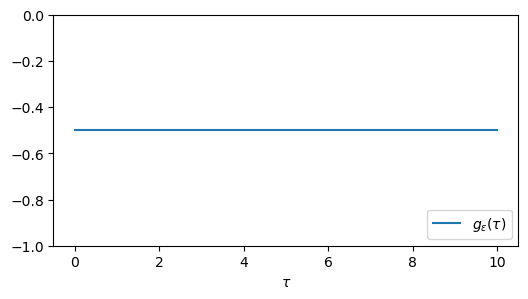

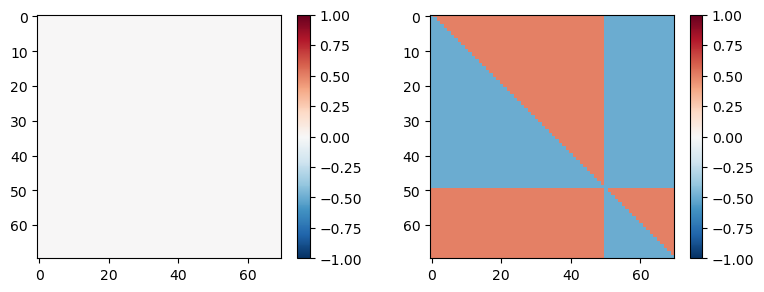

In [86]:
τ = kd.imagtimes(grid)
plt.figure(figsize=(6, 3))
plt.plot(τ, g[:matsubara], label=plt.L"$g_\varepsilon(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-1., 0]);

plot2d(g.data)

In [87]:
ed

Dimension of full Hilbert space: 4
Number of invariant subspaces: 4
  Subspace 1, dim = 1
    Basis Fock states: UInt64[0x0000000000000000]
    Energy levels: [0.0]
  Subspace 2, dim = 1
    Basis Fock states: UInt64[0x0000000000000001]
    Energy levels: [0.0]
  Subspace 3, dim = 1
    Basis Fock states: UInt64[0x0000000000000002]
    Energy levels: [0.0]
  Subspace 4, dim = 1
    Basis Fock states: UInt64[0x0000000000000003]
    Energy levels: [0.0]
Ground state energy: 0.0


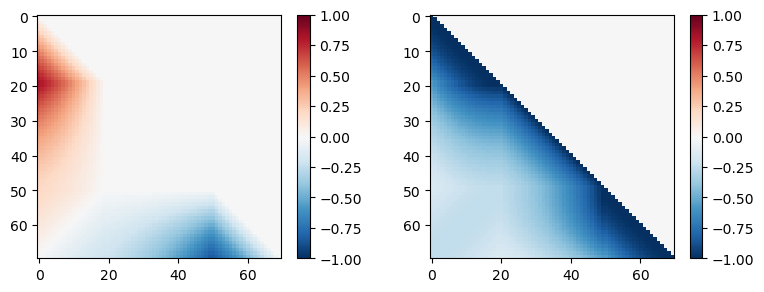

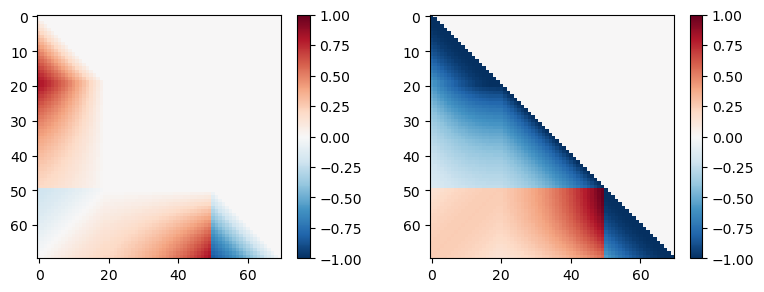

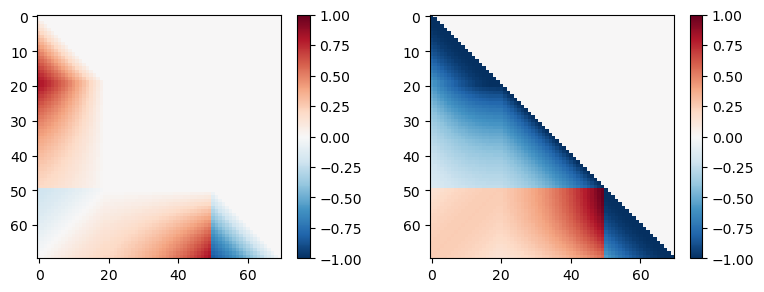

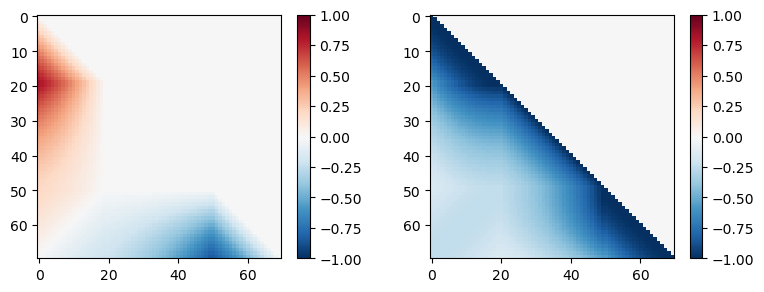

In [88]:
plot2d(G0[1].data[1, 1, :, :])
#plot2d(G0[1].data[2, 2, :, :])
#plot2d(G0[1].data[1, 2, :, :])
#plot2d(G0[1].data[2, 1, :, :])

plot2d(G0[2].data[1, 1, :, :])
plot2d(G0[3].data[1, 1, :, :])
plot2d(G0[4].data[1, 1, :, :])

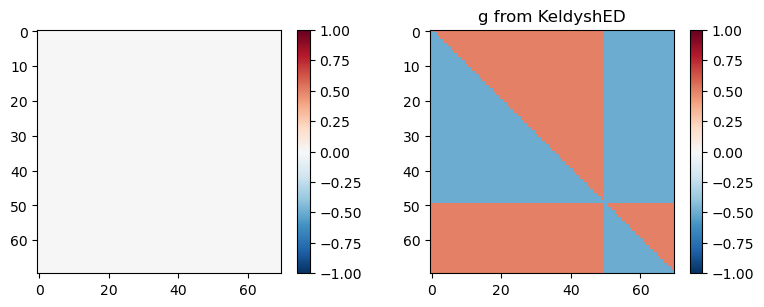

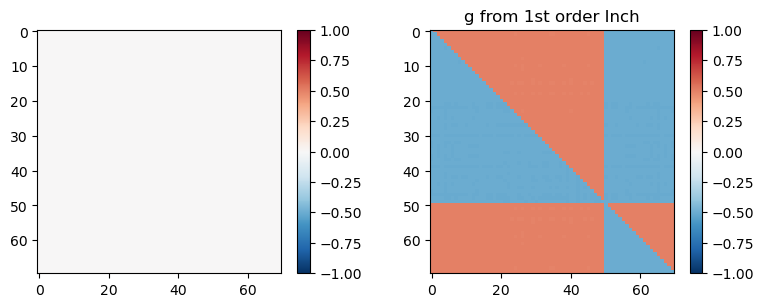

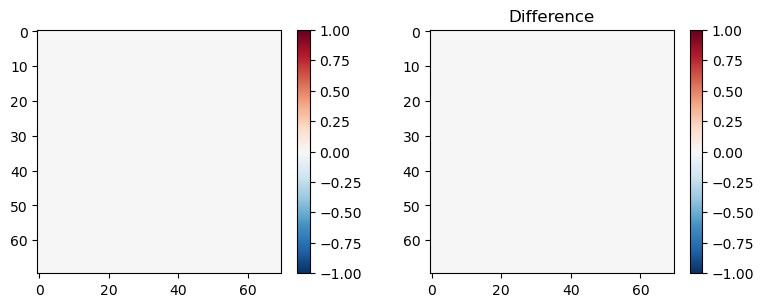

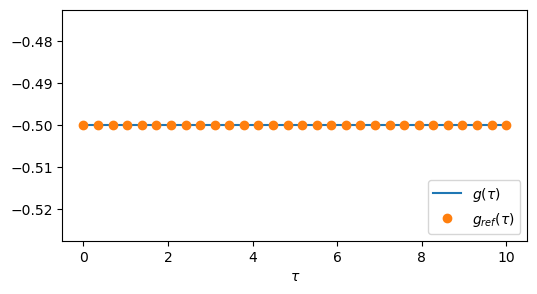

In [80]:
function first_order_spgf_dev(ppgf::Vector{S}, ed::ked.EDCore, o1, o2) where {S <: kd.TimeGF}

    grid = ppgf[1].grid
    g = kd.TimeGF(grid)
    
    for z1 in grid, z2 in grid

        sign = 1
    
        # Operator verticies
        v1 = (z1, +1, o1)
        v2 = (z2, -1, o2)
        
        # (twisted contour) time ordered operator verticies
        v1, v2 = sort([v1, v2], by = x -> x[1].idx)

        # -- Determine start and end time on twisted contour
        if z1.val.domain == kd.imaginary_branch && z2.val.domain == kd.imaginary_branch
            # Equilibrium start at \tau = 0 and end at \tau = \beta
            tau_grid = grid[kd.imaginary_branch]
            z_i, z_f = tau_grid[1], tau_grid[end]
        
            # Creation/annihilator operator commutation sign
            # why only on imaginary time branch?
            sign *= -(-1)^(z1.idx <= z2.idx)
        
        else
            # Atleast one time is in real-time            
            z_max = sort([z1, z2], 
                by = x -> real(x.val.val) - (x.val.domain == kd.imaginary_branch))[end]
            
            if z_max.val.domain == kd.forward_branch
                z_f = z_max
                z_i = grid[1 + grid[end].idx - z_max.idx]
            else
                z_i = z_max
                z_f = grid[1 + grid[end].idx - z_max.idx]
            end
        end
    
        for (sidx, s) in enumerate(ed.subspaces)
            prod = operator_product(ed, ppgf, sidx, z_i, z_f, [v1, v2])
            g[z2, z1] += -im * sign * tr(prod)
        end
    end
    return g
end

g_ref = first_order_spgf_dev(G0, ed, u, u);

plot2d(g.data)
plt.title("g from KeldyshED")

plot2d(g_ref.data)
plt.title("g from 1st order Inch")

plot2d(g.data - g_ref.data)
plt.title("Difference")

τ = kd.imagtimes(grid)
plt.figure(figsize=(6, 3))
plt.plot(τ, real(g[:matsubara]), label=plt.L"$g(\tau)$")
plt.plot(τ, real(g_ref[:matsubara]), "o", label=plt.L"$g_{ref}(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); #plt.ylim([-1., 0]);